In [1]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3770, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3770 (delta 2), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3770/3770), 143.05 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (3840/3840), done.


In [2]:
%cd Face-Mask-Detection

/content/Face-Mask-Detection


In [35]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, Model, callbacks, optimizers
from keras.applications import mobilenet_v2, MobileNetV2
from keras.utils import img_to_array, load_img, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [4]:
image_path = "/content/Face-Mask-Detection/dataset"

data = {"images":[], "labels":[]}
for i in os.listdir(image_path):
  labels = os.path.join(image_path, i)
  for j in os.listdir(labels):
    image_link = os.path.join(labels, j)
    data["images"].append(image_link)
    data["labels"].append(i)

df = pd.DataFrame(data)

df.head()

,images,labels
0,/content/Face-Mask-Detection/dataset/without_m...,without_mask
1,/content/Face-Mask-Detection/dataset/without_m...,without_mask
2,/content/Face-Mask-Detection/dataset/without_m...,without_mask
3,/content/Face-Mask-Detection/dataset/without_m...,without_mask
4,/content/Face-Mask-Detection/dataset/without_m...,without_mask


In [5]:
X = []
for i in df["images"]:
  loaded_image = img_to_array(load_img(i, target_size=(224, 224)))
  prep_image = mobilenet_v2.preprocess_input(loaded_image)
  X.append(prep_image)

X = np.array(X)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
y = np.array(to_categorical(LabelBinarizer().fit_transform(df["labels"])))

## Train Test Split

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.1)

print(Xtrain.shape, Xtest.shape)

(3449, 224, 224, 3) (384, 224, 224, 3)


## Modelling

In [8]:
mobilenet = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 1s 0us/step


In [9]:
for layer in mobilenet.layers:
  layers.trainable = False

In [10]:
mobilenet_output = mobilenet.output
x = layers.AveragePooling2D(pool_size=(5, 5))(mobilenet_output)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation="relu")(x)
x = layers.Dropout(rate=0.5)(x)
output = layers.Dense(units=2, activation="sigmoid")(x)

eddy = Model(inputs=mobilenet.input, outputs=output)

eddy.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [11]:
eddy.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [12]:
image_generator = ImageDataGenerator(rotation_range=20,
                                    zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    fill_mode="nearest")

In [15]:
eddys_history = eddy.fit(Xtrain, ytrain, batch_size=32,
                        validation_data=(Xtest, ytest),
                        steps_per_epoch=len(Xtrain)//32,
                        epochs=20,
                        callbacks=[callbacks.ReduceLROnPlateau(),
                                   callbacks.EarlyStopping(patience=4),
                                   callbacks.ModelCheckpoint(filepath=r"/content/drive/MyDrive/Colab Notebooks/FaceMask Detection/model/mobilenetv2.h5",
                                                             save_best_only=True)])

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9541

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 53s 181ms/step - loss: 0.1305 - accuracy: 0.9541 - val_loss: 0.2074 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 17s 139ms/step - loss: 0.0113 - accuracy: 0.9956 - val_loss: 0.4641 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 14s 135ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.3819 - val_accuracy: 0.9193 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 15s 137ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4076 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 21s 193ms/step - loss: 4.5707e-04 - accuracy: 1.0000 - val_loss: 0.1975 - val_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - 24s 226ms/step - loss: 5.9782e-04 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 7/20
107/107 [===========

## Model Evaluation

<Axes: >

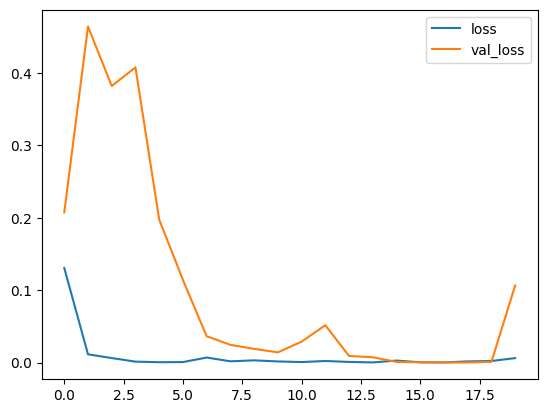

In [18]:
pd.DataFrame(eddys_history.history)[["loss", "val_loss"]].plot()

<Axes: >

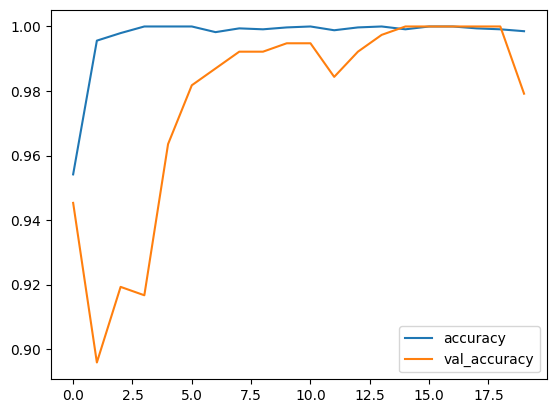

In [19]:
pd.DataFrame(eddys_history.history)[["accuracy", "val_accuracy"]].plot()

In [36]:
best_model = load_model("/content/drive/MyDrive/Colab Notebooks/FaceMask Detection/model/mobilenetv2.h5")

In [37]:
predictions = np.argmax(best_model.predict(Xtest), axis=1)

true_value = np.argmax(ytest, axis=1)

12/12 [==============================] - 1s 42ms/step


## Confusion Matrix

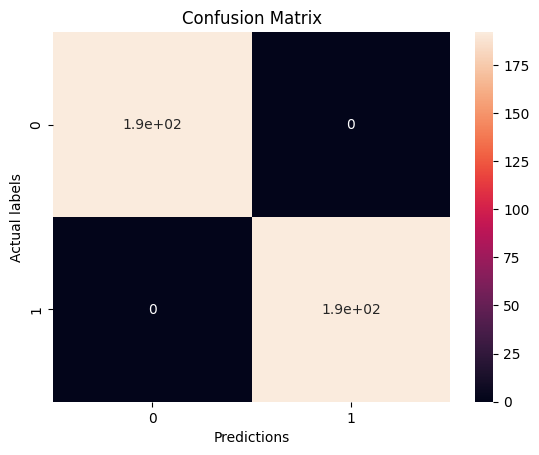

In [39]:
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred=predictions, y_true=true_value), annot=True)
plt.xlabel("Predictions")
plt.ylabel("Actual labels")
plt.show()

## Classification Report

In [40]:
print(metrics.classification_report(y_true=true_value, y_pred=predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00       192

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



## ROC CURVE

In [41]:
def Plot_ROC(y_true, y_pred):
  fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
  auc_score = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, color="red", label=f"Auc score: {auc_score}")
  plt.plot([0, 1], [0, 1], ls="--", color="black")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC CURVE")
  plt.legend()
  plt.show()

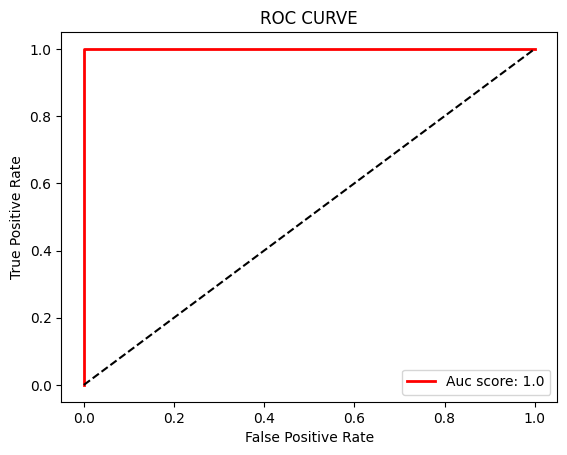

In [42]:
Plot_ROC(true_value, predictions)

## Eddy